In [9]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(purrr)


Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand





Attaching package: ‘purrr’


The following object is masked from ‘package:GenomicRanges’:

    reduce


The following object is masked from ‘package:IRanges’:

    reduce




In [8]:
gb_anno_table<- read.table("/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/N4_filtered-annotated-peaks_minfoldch5_genebody_plus_500bpStart-to-plus-600bpStop_111924.tsv",
header=T,sep="\t",comment.char="",quote="\"",stringsAsFactors=F)

pro_anno_table<- read.table("/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/N4_filtered-annotated-peaks_minfoldch5_minus-2000bp-to-plus-500bp_111623.tsv",
header=T,sep="\t",comment.char="",quote="\"",stringsAsFactors=F)


#### for each TF, get the gene list that have c4 peaks in both genebody and promoter regions

In [16]:
library(dplyr)

# Process each transcription factor and accumulate results
result_list <- lapply(unique(pro_anno_table$tf), function(i) {
    # Get gb targets
    gb_c4_target <- gb_anno_table %>%
        filter(
            species == "Arabidopsis_thaliana_Col-0",
            n_cons_species_minfrac0 == 4,
            tf == i
        ) %>%
        pull(gene) %>%
        unique()
    
    # Get pro targets
    pro_c4_target <- pro_anno_table %>%
        filter(
            species == "Arabidopsis_thaliana_Col-0",
            n_cons_species_minfrac0 == 4,
            tf == i
        ) %>%
        pull(gene) %>%
        unique()
    
    # Find common targets
    common_c4_target <- intersect(gb_c4_target, pro_c4_target)
    
    # Create a temporary data frame for the current TF
    tmp_df <- data.frame(
        TF = i,
        gb_target_num = length(gb_c4_target),
        pro_target_num = length(pro_c4_target),
        common_target_num = length(common_c4_target)
    )
    
    # Return the temporary data frame and common targets
    list(
        tmp_df = tmp_df,
        common_c4_target = common_c4_target
    )
})

# Extract and combine data frames into `tf_target_count`
tf_target_count <- do.call(rbind, lapply(result_list, `[[`, "tmp_df"))

# Create a named list of common targets
pro_gb_common_target <- setNames(
    lapply(result_list, `[[`, "common_c4_target"),
    unique(pro_anno_table$tf)
)

In [25]:
saveRDS(pro_gb_common_target,file = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/pro_gb_c4_common_target.rds")
saveRDS(tf_target_count,file = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/pro_gb_c4_common_target_number.rds")

In [39]:
tf_target_count <- readRDS(file = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/pro_gb_c4_common_target_number.rds")

In [40]:
head(tf_target_count)

,TF,gb_target_num,pro_target_num,common_target_num
,<chr>,<int>,<int>,<int>
1,AT1G01060,200,959,25
2,AT1G01250,218,472,17
3,AT1G01720,142,169,0
4,AT1G02230,3080,1439,287
5,AT1G02250,3452,1968,467
6,AT1G03800,786,2159,163


In [20]:
labels = read.table('/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/ath-258-tf-info_simple.csv', sep=',', header=T,stringsAsFactors = F)

In [32]:

tf_target_count <- tf_target_count %>%
    left_join(labels,by=join_by(TF==gene_id)) %>%
    arrange(tf_family) %>%
    mutate(TF_position = row_number())


long_data <- tf_target_count %>%
    select(TF, tf_name,tf_family, TF_position, gb_target_num, pro_target_num, common_target_num) %>%
    pivot_longer(cols = c(gb_target_num, pro_target_num, common_target_num),
               names_to = "Target_Type",
               values_to = "Count")

# Define colors for shading and lines
family_colors <- c("Family1" = "#FFCCCC", "Family2" = "#CCE5FF", "Family3" = "#D5F5E3")
line_colors <- c("gb_target_num" = "blue", "pro_target_num" = "green", "common_target_num" = "red")

In [53]:
head(long_data)

TF,tf_name,tf_family,TF_position,Target_Type,Count
<chr>,<chr>,<chr>,<int>,<chr>,<int>
AT3G18990,VRN1,ABI3VP1,1,gb_target_num,275
AT3G18990,VRN1,ABI3VP1,1,pro_target_num,1796
AT3G18990,VRN1,ABI3VP1,1,common_target_num,60
AT4G01500,NGA4,ABI3VP1,2,gb_target_num,353
AT4G01500,NGA4,ABI3VP1,2,pro_target_num,37
AT4G01500,NGA4,ABI3VP1,2,common_target_num,3


In [38]:
head(tf_target_count)

,TF,gb_target_num,pro_target_num,common_target_num,tf_family,tf_name,tf_and_fam,representative_category,tf_clade_curated,clade,TF_position
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>
1,AT3G18990,275,1796,60,ABI3VP1,VRN1,ABI3VP1_VRN1,2,3,ABI3VP1_c3,1
2,AT4G01500,353,37,3,ABI3VP1,NGA4,ABI3VP1_NGA4,0,1,ABI3VP1_c1,2
3,AT5G60130,289,1182,38,ABI3VP1,AT5G60130,ABI3VP1_AT5G60130,1,2,ABI3VP1_c2,3
4,AT1G01250,218,472,17,AP2EREBP,AT1G01250,AP2EREBP_AT1G01250,0,1,AP2EREBP_c1,4
5,AT1G03800,786,2159,163,AP2EREBP,ERF10,AP2EREBP_ERF10,0,1,AP2EREBP_c1,5
6,AT1G12610,377,593,13,AP2EREBP,DDF1,AP2EREBP_DDF1,0,2,AP2EREBP_c2,6


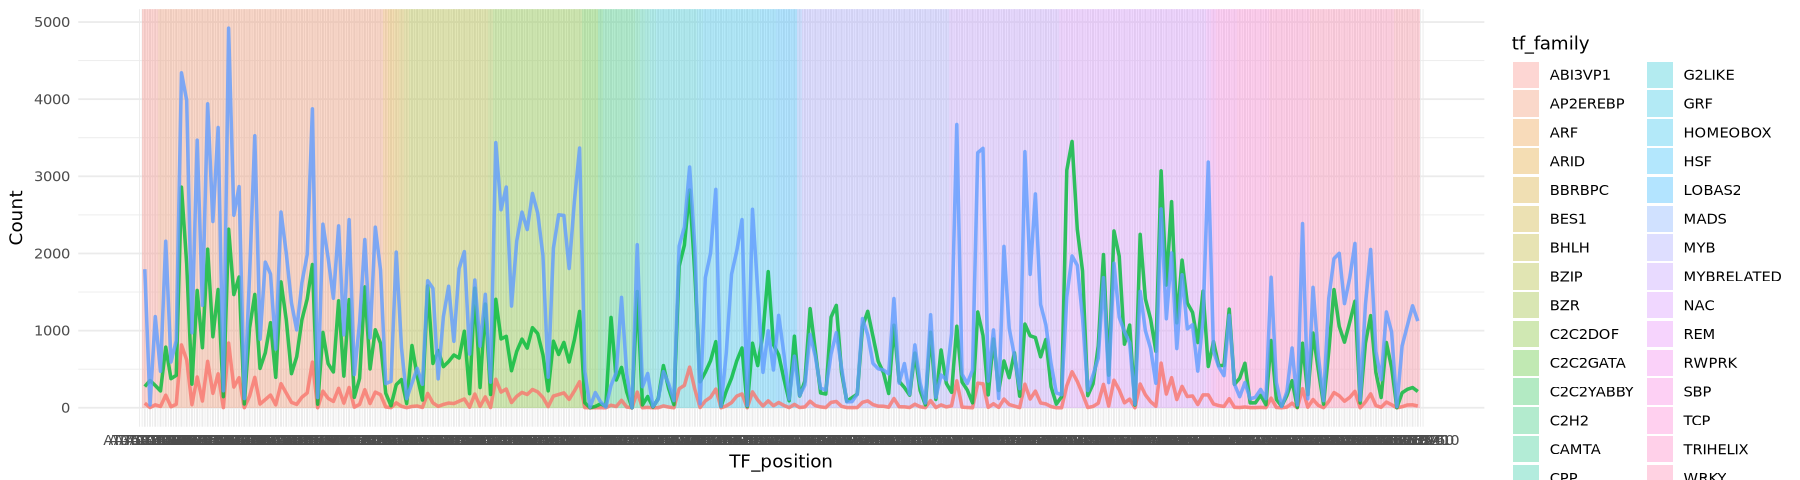

In [45]:
options(repr.plot.width=15,repr.plot.height=4,resolution=300)
ggplot() +
  geom_rect(data = tf_target_count,
            aes(xmin = TF_position - 0.5, xmax = TF_position + 0.5, ymin = +0, ymax = Inf, fill = tf_family),
            alpha = 0.3) +
  # Add shaded rectangles for TF families
  geom_line(data = long_data, 
            aes(x = TF_position, y = Count, color = Target_Type), 
            size = 1, alpha = 0.8)+
  scale_x_continuous(breaks = tf_target_count$TF_position, labels = tf_target_count$TF) +
  theme_minimal() 
    

In [60]:
unique(long_data$tf_family)

[1] "ABI3VP1"    "AP2EREBP"   "ARF"        "ARID"       "BBRBPC"    
 [6] "BES1"       "BHLH"       "BZIP"       "BZR"        "C2C2DOF"   
[11] "C2C2GATA"   "C2C2YABBY"  "C2H2"       "CAMTA"      "CPP"       
[16] "E2FDP"      "EIL"        "G2LIKE"     "GRF"        "HOMEOBOX"  
[21] "HSF"        "LOBAS2"     "MADS"       "MYB"        "MYBRELATED"
[26] "NAC"        "REM"        "RWPRK"      "SBP"        "TCP"       
[31] "TRIHELIX"   "WRKY"       "ZFHD"

In [86]:
library(randomcoloR)

In [91]:
color_use <- distinctColorPalette(33)

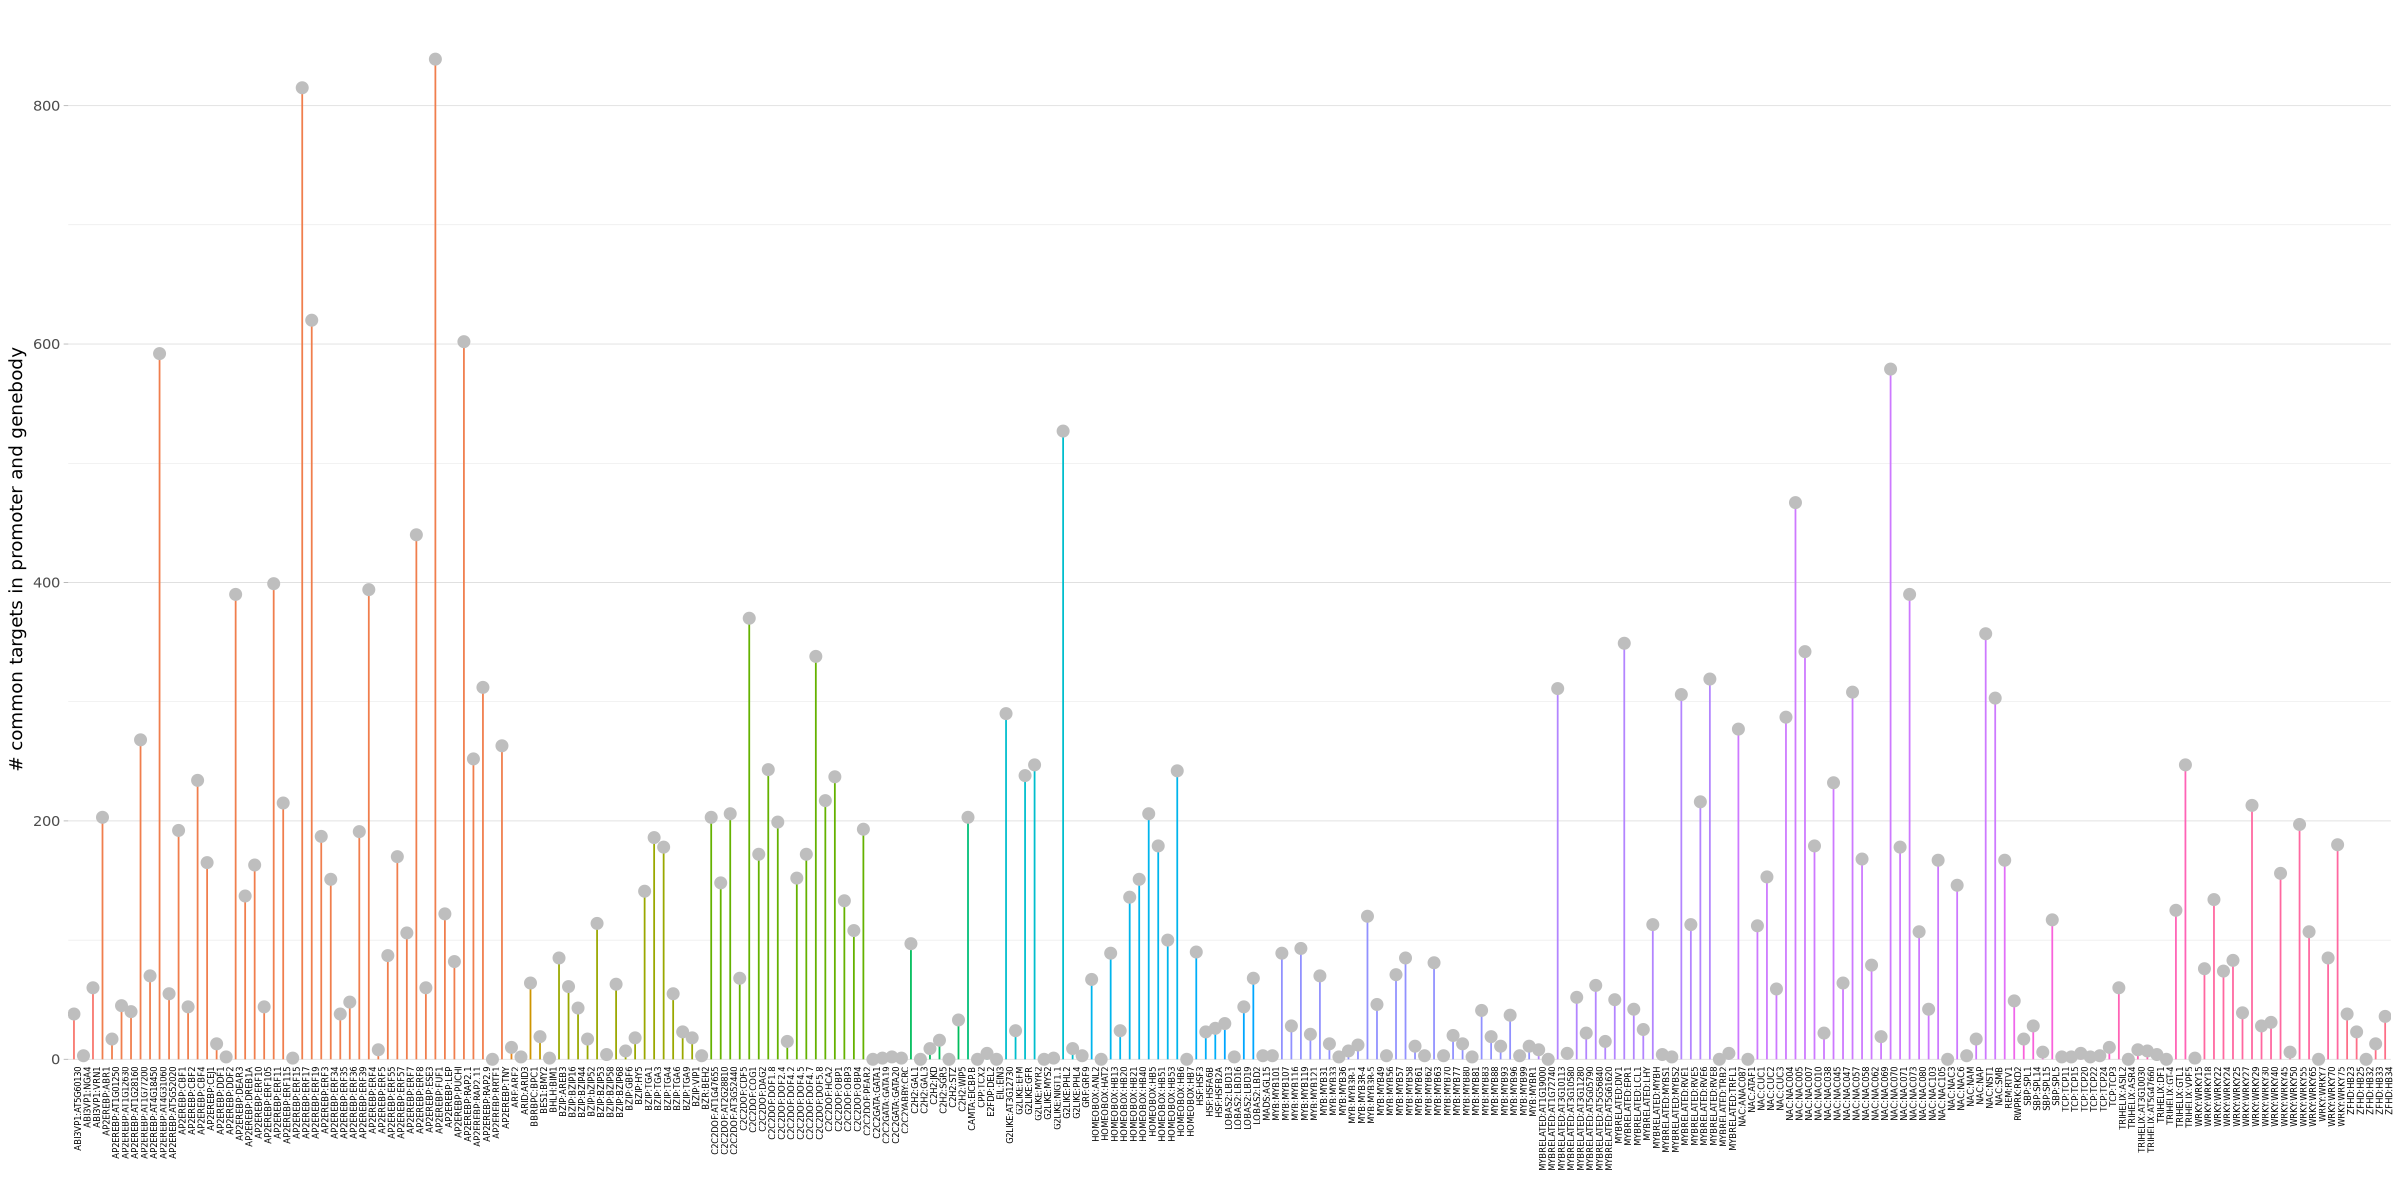

In [101]:
options(repr.plot.width=20,repr.plot.height=10,resolution=300)
long_data %>%
filter(Target_Type=="common_target_num") %>%
mutate(tf_name=factor(tf_name,levels = unique(tf_name))) %>%
mutate(plot_label=paste(tf_family,tf_name,sep = ":"))%>%
ggplot(aes(x=plot_label, y=Count)) +
  geom_segment(aes(x=plot_label, xend=plot_label, y=0, yend=Count,color=tf_family)) +
  geom_point(color="grey", size=3) +
  theme_light() +
  theme(
    panel.grid.major.x = element_blank(),
    axis.text.x=element_text(size=5,angle=90,color="black",hjust = 1,margin = margin(-1,0,0,0,unit = "cm")),
    panel.border = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position="None"
  ) +
  xlab("") +
  ylab("# common targets in promoter and genebody")


#### perform GO analysis fro each TF of their common target 

In [6]:
library(clusterProfiler)
library(org.At.tair.db)



clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang,
W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize
multiomics data. Nature Protocols. 2024, doi:10.1038/s41596-024-01020-z


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, 

In [117]:
go_res_list <- lapply(pro_gb_common_target,
function(target_ls){
    if(length(target_ls)>10){
        enrichGO(target_ls,
            OrgDb = org.At.tair.db,
            keyType = "TAIR",
            ont = "BP")
    }
})

In [118]:
names(go_res_list) <- names(pro_gb_common_target)

In [119]:
saveRDS(go_res_list,file = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/tf_promoter_gb_common_target_GO.rds")

In [122]:
simplified_go <- lapply(go_res_list,function(x){
    if(!is.null(x)){
        simplify(x, by = "pvalue")@result
    }
})


In [132]:
head(simplified_go$AT1G01060)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016104,GO:0016104,triterpenoid biosynthetic process,3/17,16/21061,2.430285e-07,3.66973e-05,2.558195e-05,AT3G29255/AT5G36150/AT1G78970,3
GO:0006722,GO:0006722,triterpenoid metabolic process,3/17,21/21061,5.757550e-07,4.34695e-05,3.030289e-05,AT3G29255/AT5G36150/AT1G78970,3


In [135]:
GO_for_plot<- 
do.call(rbind,lapply(seq_len(length(simplified_go)),
function(x){
    if(!is.null(simplified_go[[x]])){
        return(data.frame(TF=names(simplified_go)[x],
        GO_term=simplified_go[[x]][1:3,"Description"],
        GO_adj_p=simplified_go[[x]][1:3,"p.adjust"]))
    }
}))

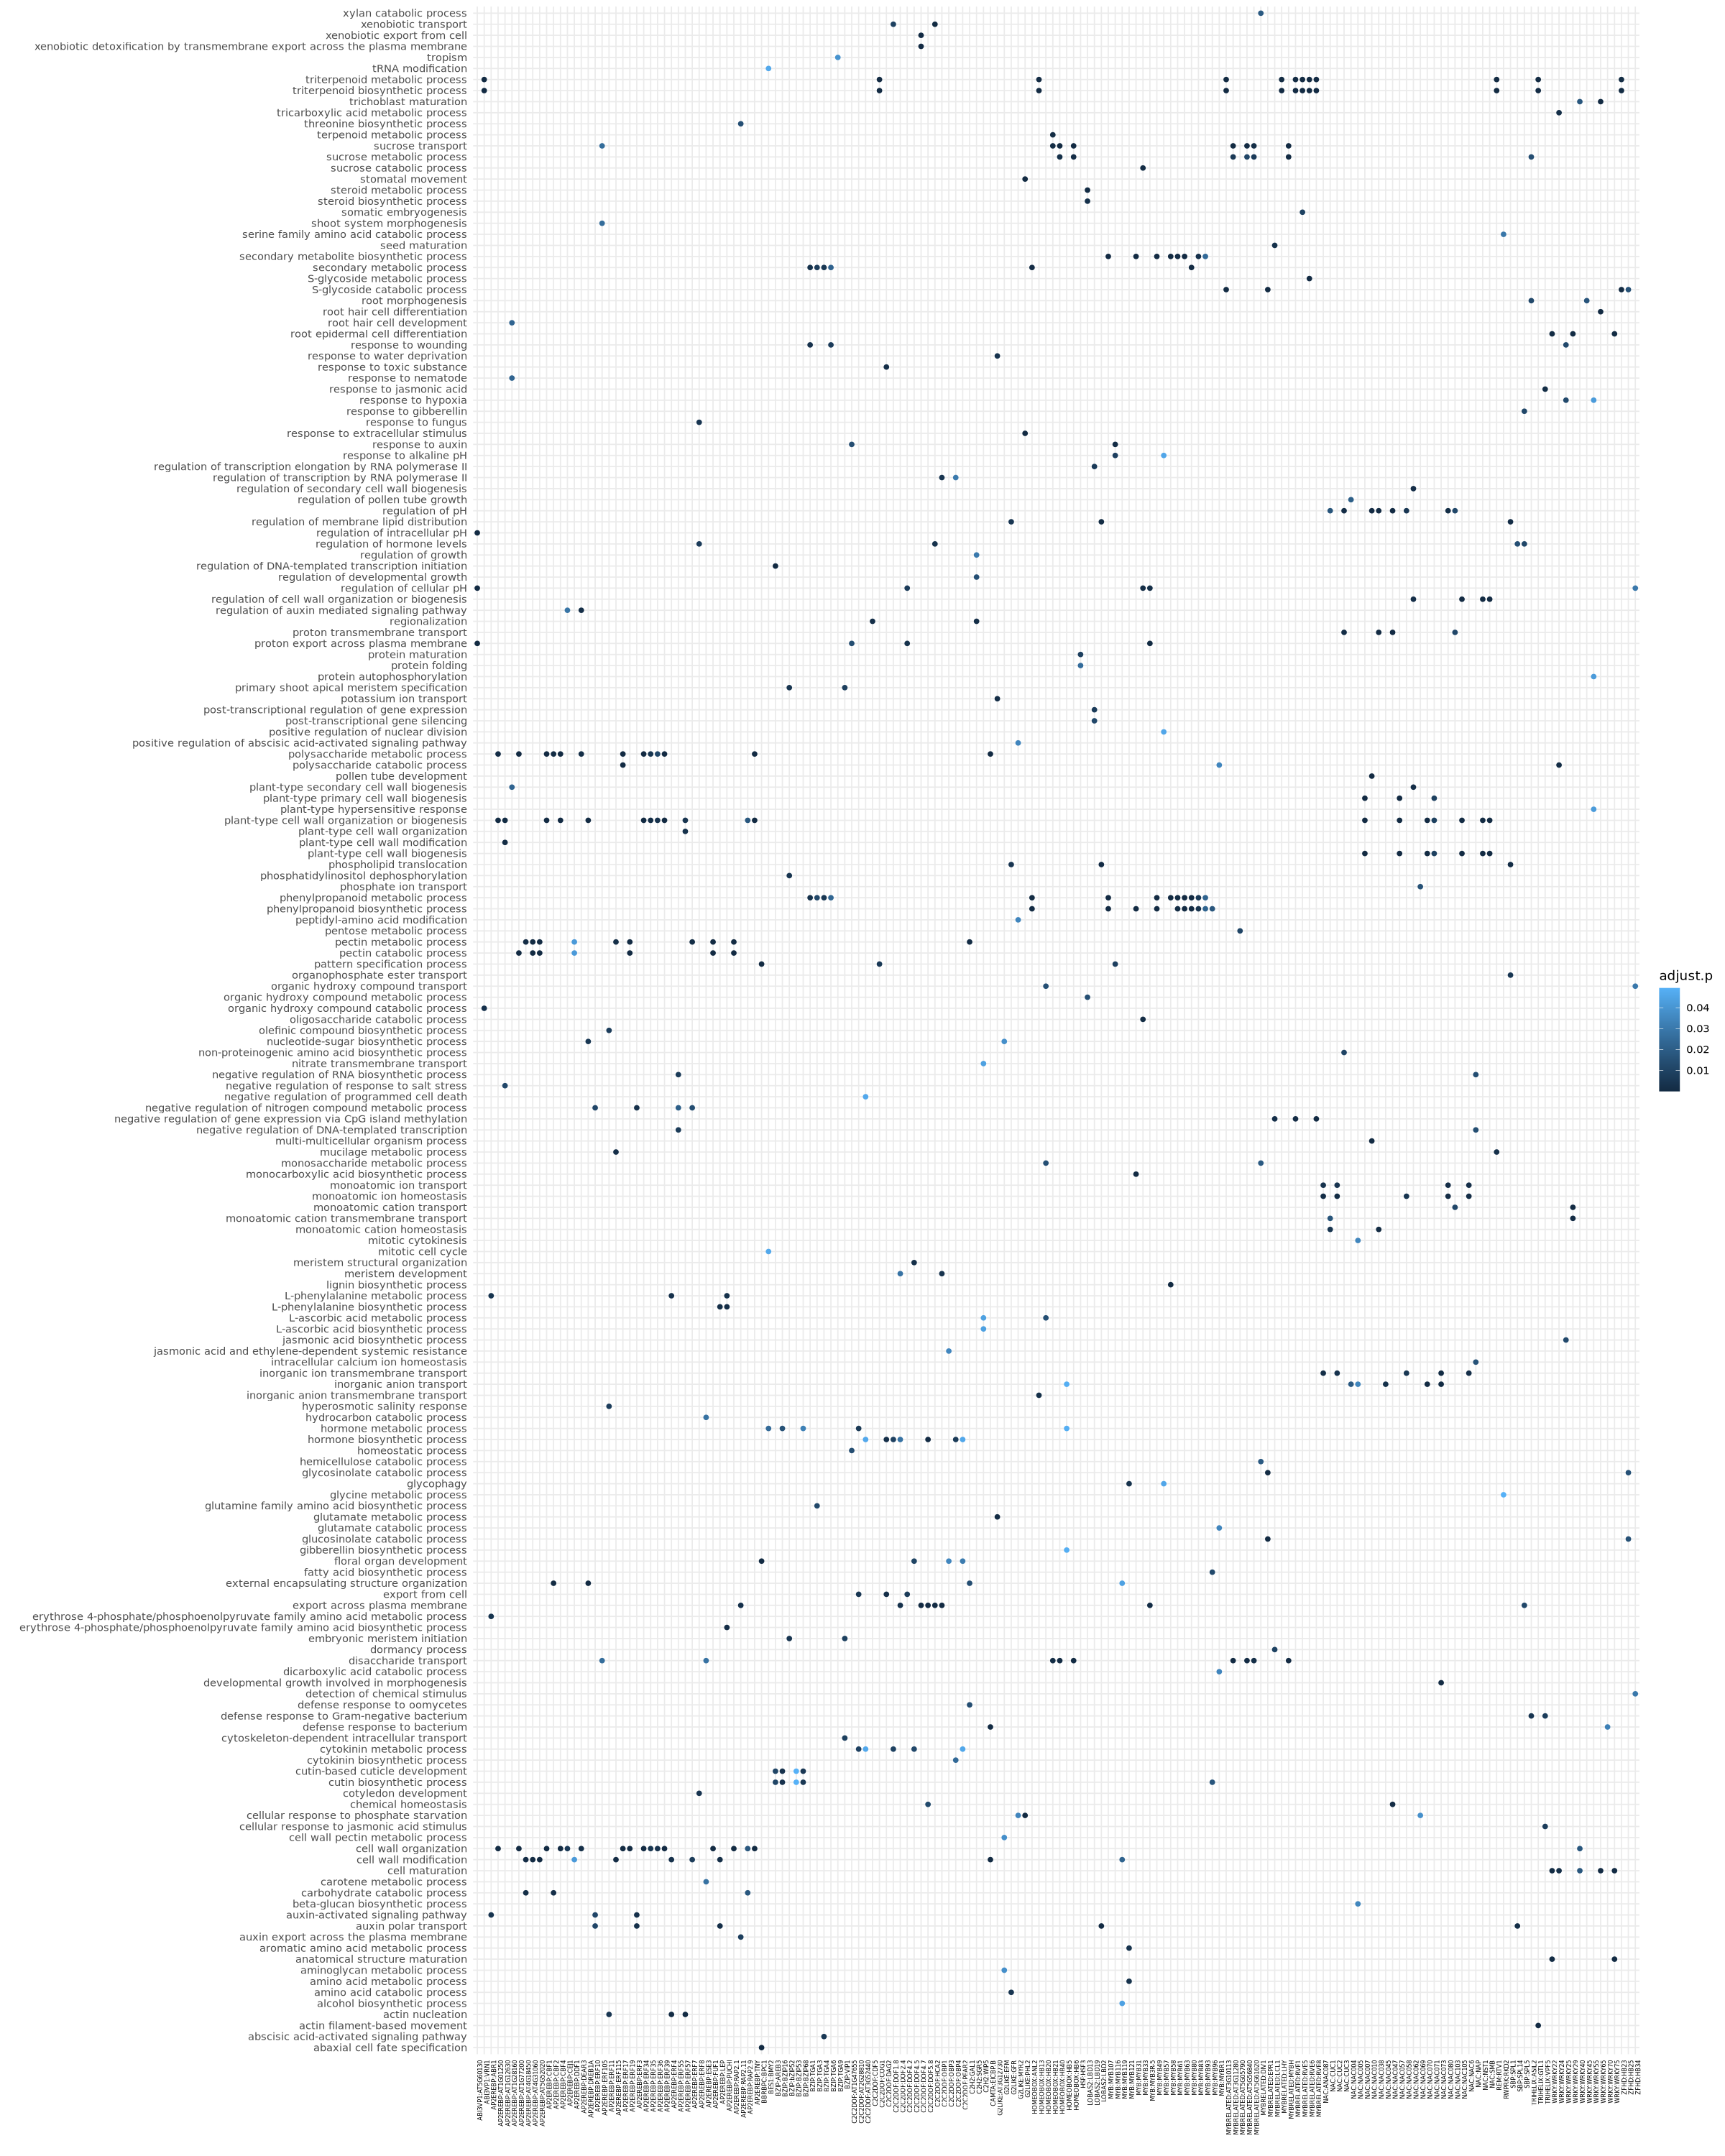

In [149]:
options(repr.plot.width=20,repr.plot.height=25,resolution=300)
p <- GO_for_plot %>%
    filter(!is.na(GO_term)) %>%
    left_join(labels,by=join_by(TF==gene_id)) %>%
    arrange(tf_family) %>%
    mutate(tf_name=factor(tf_name,levels = unique(tf_name))) %>%
    mutate(plot_label=paste(tf_family,tf_name,sep = ":"))%>%
    ggplot(aes(x=plot_label,y=GO_term,color=GO_adj_p))+
    geom_point()+
    #facet_wrap(.~tf_family,ncol = 5,scales = "free")+
    theme_minimal()+
    theme(axis.text.x = element_text(size=5,angle=90,color="black",hjust = 1 ))+
    labs(x="",y="",color="adjust.p")
p

In [150]:
ggsave(p,filename = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/tf_promoter_gb_common_target_GO_dotplot.pdf",width = 20,height = 25)

GO functions of c1-c4 targets

In [7]:
library(purrr)


Attaching package: ‘purrr’


The following object is masked from ‘package:IRanges’:

    reduce


The following object is masked from ‘package:clusterProfiler’:

    simplify




In [17]:
gb_anno_table %>%
    filter(tf=="AT1G01250") %>%
    dplyr::select(gene,n_cons_species_minfrac0) %>%
    head()

,gene,n_cons_species_minfrac0
,<chr>,<int>
1,AT3G54800,2
2,AT4G35320,3
3,AT5G05090,3
4,AT3G28180,4
5,AT4G01840,4
6,AT4G31590,4


In [19]:
gb_anno_table %>%
    filter(tf=="AT1G01250") %>%
    dplyr::select(gene,n_cons_species_minfrac0) %>%
    group_by(n_cons_species_minfrac0) %>%
    head()

gene,n_cons_species_minfrac0
<chr>,<int>
AT3G54800,2
AT4G35320,3
AT5G05090,3
AT3G28180,4
AT4G01840,4
AT4G31590,4


In [33]:
TF="AT1G01250"
gb_anno_table %>%
        filter(tf==TF) %>%
        dplyr::select(gene,n_cons_species_minfrac0) %>%
        group_by(n_cons_species_minfrac0) %>%
        group_map(~enrichGO(.x$gene,
                OrgDb = org.At.tair.db,
                keyType = "TAIR",
                ont = "BP")%>% 
                clusterProfiler::simplify(by = "pvalue") %>% 
                as.data.frame() %>%
                filter(p.adjust<0.05)) %>%
        map_dfr(~ .x, .id = "n_cons_species_minfrac0") ->go_tmp_df

In [9]:

tf_list <- unique(gb_anno_table$tf)
TF_cgroup_target_go_ls <- 
lapply(tf_list, function(TF) {
    gb_anno_table %>%
        filter(tf == TF) %>%
        dplyr::select(gene, n_cons_species_minfrac0) %>%
        group_by(n_cons_species_minfrac0) %>%
        group_map(~ {
            result <- enrichGO(
                gene          = .x$gene,
                OrgDb         = org.At.tair.db,
                keyType       = "TAIR",
                ont           = "BP"
            )
            if (!is.null(result)) {
                result <-  gofilter(result,level = 6)%>% clusterProfiler::simplify( by = "pvalue")
                result <- as.data.frame(result)
                result <- result %>% filter(p.adjust < 0.05)
                return(result)
            } else {
                return(NULL) # Skip groups with no results
            }
        }) %>%
        discard(is.null) %>% # Remove NULL results
        map_dfr(~ .x, .id = "n_cons_species_minfrac0") -> go_tmp_df
    
    if (nrow(go_tmp_df) > 0) {
        go_tmp_df$TF <- TF
        return(go_tmp_df)
    } else {
        return(NULL) # Return NULL if no results for the TF
    }
})



No gene sets have size between 10 and 500 ...

--> return NULL...



In [10]:
saveRDS(TF_cgroup_target_go_ls,file = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/TF_gb_cons_target_padj0.05_GO_list.rds")

In [2]:
TF_cgroup_target_go_ls <- readRDS(file = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/TF_gb_cons_target_padj0.05_GO_list.rds")

In [11]:
length(TF_cgroup_target_go_ls)

[1] 244

In [12]:
do.call(rbind,TF_cgroup_target_go_ls) -> full_go_df

In [13]:
library(dplyr)

In [18]:

full_go_df %>%
 dplyr::filter(TF %in% c("AT5G09410")) %>%
 arrange(pvalue)

,n_cons_species_minfrac0,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,TF
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0005976...1,4,GO:0005976,polysaccharide metabolic process,68/1166,466/21061,2.161038e-13,3.844486e-10,3.148291e-10,AT1G32170/AT5G53370/AT1G02640/AT5G07720/AT4G36870/AT4G08160/AT3G62720/AT3G54920/AT1G27440/AT5G04970/AT3G49220/AT3G14570/AT5G09760/AT5G64640/AT3G50220/AT1G19300/AT3G24670/AT4G03550/AT1G08990/AT3G47010/AT1G11720/AT5G04310/AT3G42160/AT2G27500/AT1G54940/AT5G40870/AT3G14300/AT1G24170/AT1G67140/AT2G31960/AT4G28490/AT1G14420/AT1G70230/AT3G47050/AT4G33330/AT3G27400/AT1G44120/AT2G44610/AT3G29360/AT3G47040/AT5G13000/AT3G10720/AT2G23760/AT5G11420/AT1G53830/AT4G28370/AT2G02720/AT4G02500/AT3G62660/AT5G36870/AT2G26450/AT5G20940/AT5G51490/AT4G13710/AT4G18240/AT5G20950/AT2G28760/AT3G07160/AT3G47400/AT4G33230/AT1G18690/AT2G33100/AT2G36390/AT3G50120/AT3G18660/AT5G67210/AT3G01270/AT3G59100,68,AT5G09410
GO:000027239,4,GO:0000272,polysaccharide catabolic process,29/1166,143/21061,9.765952e-10,8.686814e-07,7.113725e-07,AT5G53370/AT1G02640/AT4G08160/AT3G54920/AT5G04970/AT3G49220/AT5G09760/AT5G64640/AT3G24670/AT3G47010/AT5G04310/AT3G42160/AT3G14300/AT4G28490/AT1G14420/AT3G47050/AT3G27400/AT3G47040/AT3G10720/AT1G53830/AT2G02720/AT2G26450/AT5G20940/AT5G51490/AT4G13710/AT5G20950/AT3G47400/AT4G33230/AT3G01270,29,AT5G09410
GO:004522955,4,GO:0045229,external encapsulating structure organization,50/1166,364/21061,2.800965e-09,1.660972e-06,1.360188e-06,AT1G24140/AT1G70710/AT5G53370/AT4G27420/AT2G28950/AT1G07000/AT3G03220/AT3G54920/AT5G04970/AT1G02050/AT2G19070/AT3G49220/AT4G16640/AT5G09760/AT5G64640/AT1G19300/AT4G20050/AT5G63800/AT4G03550/AT5G04310/AT3G42160/AT2G20650/AT3G14300/AT4G34980/AT1G14420/AT1G64760/AT5G02260/AT3G29030/AT2G44610/AT3G29360/AT5G47820/AT3G10720/AT5G11420/AT1G53830/AT4G28370/AT5G58100/AT1G70370/AT5G23870/AT1G13980/AT2G26450/AT5G51490/AT3G07160/AT3G47400/AT4G33230/AT1G24100/AT1G09550/AT1G01280/AT4G19180/AT5G46330/AT1G19900,50,AT5G09410
GO:0098660...4,4,GO:0098660,inorganic ion transmembrane transport,38/1166,269/21061,1.060649e-07,1.886894e-05,1.545198e-05,AT2G40116/AT1G78900/AT4G22990/AT1G71880/AT1G08140/AT3G26570/AT2G30240/AT5G14570/AT1G31120/AT4G19960/AT4G38530/AT5G58700/AT5G58670/AT1G69870/AT5G22900/AT4G11730/AT1G32450/AT3G45700/AT3G45680/AT3G60330/AT1G63010/AT4G23640/AT2G31910/AT3G16180/AT2G13620/AT5G22910/AT3G44920/AT5G14880/AT5G14870/AT5G37060/AT3G06100/AT2G18960/AT3G06370/AT1G16380/AT3G57330/AT3G44930/AT1G15460/AT1G18880,38,AT5G09410
GO:000607445,4,GO:0006074,(1->3)-beta-D-glucan metabolic process,8/1166,14/21061,1.918752e-07,2.888768e-05,2.365643e-05,AT3G14570/AT4G03550/AT2G27500/AT2G31960/AT5G13000/AT5G36870/AT3G07160/AT3G59100,8,AT5G09410
GO:001605136,4,GO:0016051,carbohydrate biosynthetic process,46/1166,367/21061,1.948579e-07,2.888768e-05,2.365643e-05,AT5G07720/AT3G62720/AT4G39940/AT1G27440/AT5G56490/AT3G14570/AT1G70290/AT3G50220/AT1G19300/AT2G46750/AT4G12430/AT4G03550/AT1G08990/AT1G11720/AT3G05120/AT1G32060/AT1G06410/AT1G54940/AT1G24170/AT1G67070/AT2G31960/AT4G33330/AT1G44120/AT2G44610/AT5G65690/AT5G13000/AT4G22590/AT4G28370/AT4G26260/AT4G02500/AT3G62660/AT5G36870/AT1G04920/AT4G18240/AT5G20950/AT1G32300/AT2G28760/AT3G07160/AT5G27320/AT1G18690/AT2G33100/AT2G36390/AT3G18660/AT5G67210/AT3G59100/AT2G46740,46,AT5G09410
GO:0006885...7,4,GO:0006885,regulation of pH,16/1166,64/21061,2.764261e-07,3.782785e-05,3.097763e-05,AT4G39080/AT1G08140/AT2G30240/AT5G22900/AT4G11730/AT3G60330/AT2G21410/AT2G31910/AT2G13620/AT5G22910/AT3G44920/AT5G37060/AT2G18960/AT3G06370/AT1G16380/AT3G44930,16,AT5G09410
GO:0006811...8,4,GO:0006811,monoatomic ion transport,44/1166,354/21061,4.524180e-07,5.748940e-05,4.707868e-05,AT2G40116/AT2G29120/AT1G78900/AT1G71880/AT1G08140/AT2G29110/AT1G01140/AT2G30240/AT1G31120/AT4G19960/AT4G38530/AT5G58700/AT4G22120/AT5G58670/AT5G22900/AT3G45710/AT4G11730/AT5G37500/AT1G32450/AT3G45700/AT3G60330/AT4G23640/AT2G31910/AT2G32400/AT2G13620/AT5G61350/AT

In [14]:
do.call(rbind,TF_cgroup_target_go_ls) %>%
    mutate(TF_target_num=as.numeric(stringr::str_split(GeneRatio,"/",simplify=T)[,2])) %>%
    group_by(n_cons_species_minfrac0,TF,TF_target_num) %>%
    tally()%>%
    head()

n_cons_species_minfrac0,TF,TF_target_num,n
<chr>,<chr>,<dbl>,<int>
1,AT1G27730,561,1
1,AT1G28160,120,4
1,AT1G49010,686,2
1,AT1G75390,425,4
1,AT2G30250,748,1
1,AT2G33550,257,1


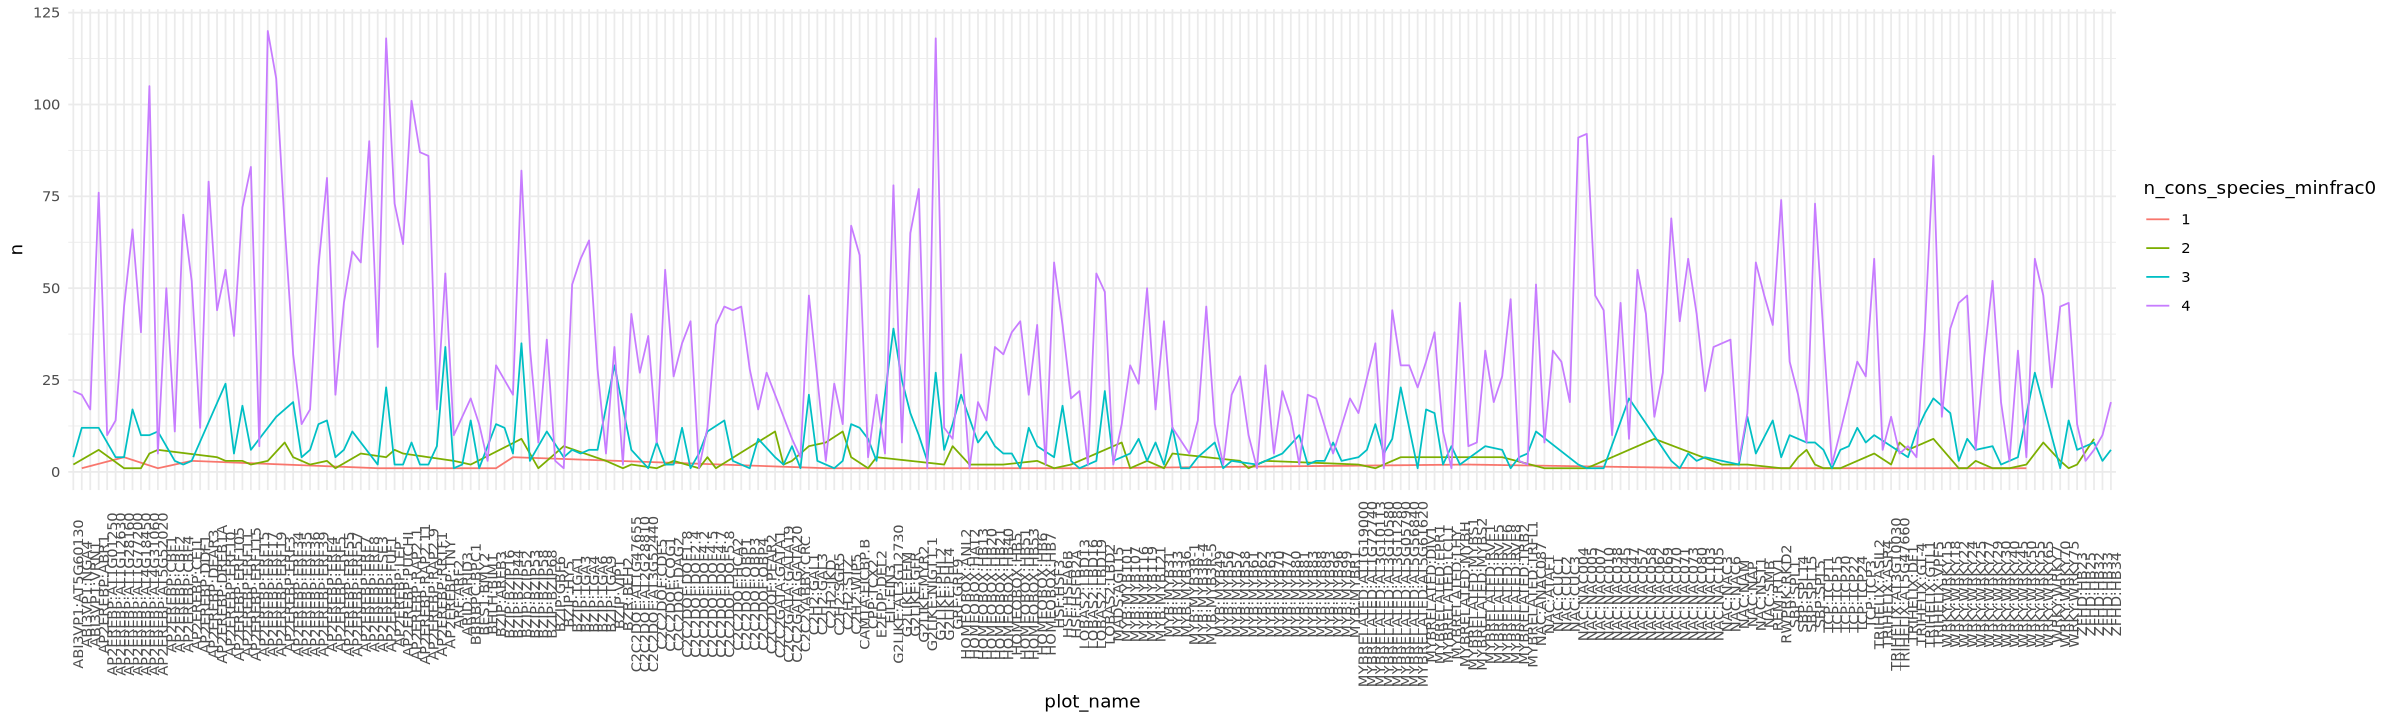

In [23]:
options(repr.plot.width=20,repr.plot.height=6,resolution=300)
do.call(rbind,TF_cgroup_target_go_ls) %>%
    mutate(TF_target_num=as.numeric(stringr::str_split(GeneRatio,"/",simplify=T)[,2])) %>%
    group_by(n_cons_species_minfrac0,TF,TF_target_num) %>%
    tally()%>%
    left_join(labels,by=c("TF"="gene_id")) %>%
    mutate(plot_name=paste0(tf_family,":",tf_name))%>%
    ggplot(aes(x=plot_name,y=n,color=n_cons_species_minfrac0,group=n_cons_species_minfrac0))+
    geom_line()+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90))

`geom_smooth()` using formula = 'y ~ x'


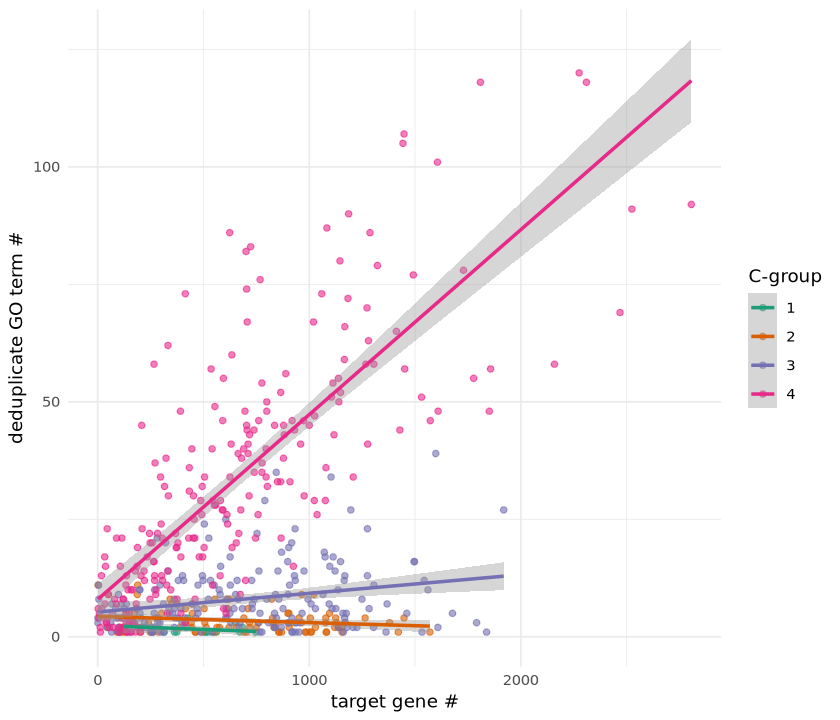

In [22]:
## but is the GO term number related to the total gene counts in different c-groups
options(repr.plot.width=7,repr.plot.height=6,resolution=600)
do.call(rbind,TF_cgroup_target_go_ls) %>%
    mutate(TF_target_num=as.numeric(stringr::str_split(GeneRatio,"/",simplify=T)[,2])) %>%
    group_by(n_cons_species_minfrac0,TF,TF_target_num) %>%
    tally()%>%
    left_join(labels,by=c("TF"="gene_id")) %>%
    #mutate(plot_name=paste0(tf_family,":",tf_name))%>%
    ggplot(aes(x=TF_target_num,y=n,color=n_cons_species_minfrac0))+
    geom_point(alpha=0.6)+
    stat_smooth(method="lm")+
    theme_minimal()+
    scale_color_brewer(palette = "Dark2")+
    labs(color="C-group",x="target gene #",y="deduplicate GO term #")

## compare the overlap between downstream/upstream targets

In [ ]:
tf_target_count <- readRDS(file = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/pro_gb_c4_common_target_number.rds")

In [71]:
options(repr.plot.width=20,repr.plot.height=6,resolution=600)
(tf_target_count %>%
    left_join(labels,by=c("TF"="gene_id")) %>%
    select(contains("num"),tf_and_fam) %>%
    filter(tf_and_fam!="C2H2_AT5G22990")%>%
    pivot_longer(cols = c("gb_target_num","pro_target_num","common_target_num")) %>%
    mutate(group=case_when(name=="gb_target_num" ~ "genebody",name=="pro_target_num" ~ "promoter",.default = "common")) %>%
    ggplot(aes(x=tf_and_fam,y=value,fill=group))+
    geom_col(position = "fill",width = 1,color="grey")+
    geom_hline(yintercept = 0.5,linetype="dashed",color="black")+
    theme_minimal()+
    scale_y_continuous(expand = c(0,0))+
    theme(axis.text.x=element_text(size=5,angle=90,color="black",hjust = 1,margin = margin(0,0,0,0,unit = "cm")))+
    scale_fill_manual(values=c("#beaed4","#fdc086","#7fc97f"))+
    labs(x="",y="% of target")) %>%
    ggsave(filename = "/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/tf_pro_gb_common_target_prop.pdf",width = 20,height=6)

In [ ]:
## stress inducibility of common target

In [1]:
pro_gb_c4_common_target <- readRDS("/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/pro_gb_c4_common_target.rds")

In [4]:
heat_DESeq_res <- readRDS("/clusterfs/jgi/groups/gentech/homes/romalley/stress_bulk_RNAseq/analysis/heat_DESeq2_res.rds")

salt_2h_DESeq_res <- readRDS("/clusterfs/jgi/groups/gentech/homes/romalley/stress_bulk_RNAseq/analysis/salt_h_vsWT_DESeq2_res.rds")

salt_24h_DESeq_res <- readRDS("/clusterfs/jgi/groups/gentech/homes/romalley/stress_bulk_RNAseq/analysis/salt_24h_vsWT_DESeq2_res.rds")

ABA_2h_DESeq_res <- readRDS("/clusterfs/jgi/groups/gentech/homes/romalley/stress_bulk_RNAseq/analysis/ABA_2h_vsWT_DESeq2.rds")

ABA_4h_DESeq_res <- readRDS("/clusterfs/jgi/groups/gentech/homes/romalley/stress_bulk_RNAseq/analysis/ABA_4h_vsWT_DESeq2.rds")


In [30]:
Athalia_all_peak <- read.table("/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/Athaliana_promoter_gb_integrage.tsv",header = T,sep = "\t",quote = "\"",comment.char="")

In [49]:
deseq2_df <- as.data.frame(ABA_2h_DESeq_res)
row.names(deseq2_df) <- stringr::str_split(row.names(deseq2_df),"\\.",simplify=T)[,1]

In [45]:
labels = read.table('/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/ath-258-tf-info_simple.csv', sep=',', header=T,stringsAsFactors = F)

In [51]:
## iterate each TF
TF_ls<- names(pro_gb_c4_common_target)

for(TF in TF_ls){
    if(length(pro_gb_c4_common_target[[TF]])>0){
        Athalia_all_peak %>% filter(tf==!!TF & n_cons_species_minfrac0==4 & summit_to_cds_start<500) %>% pull(gene) %>% unique() %>% setdiff(pro_gb_c4_common_target[[TF]]) -> TF_sole_target
        deseq2_df$label <- ifelse(row.names(deseq2_df) %in% pro_gb_c4_common_target[[TF]],"common",
                                  ifelse(row.names(deseq2_df) %in% TF_sole_target, "pro","non"))

        p_value <- kruskal.test(log2FoldChange~label,deseq2_df)$p.value
        TF_family <- labels %>% filter(gene_id==TF) %>% pull(tf_family)
        TF_name <- labels %>% filter(gene_id==TF) %>% pull(tf_name)
    

        (deseq2_df %>%
            ggplot(aes(x=label,y=log2FoldChange))+
            geom_violin()+
            scale_y_continuous(limits = c(-5,5))+
            theme_minimal()+
            stat_summary(fun = median, fun.min = median, fun.max = median,
                 geom = "crossbar", 
                 width = 0.6) +
            labs(title=paste0(TF_name,":",TF_family,"\n","pro_gb_gene:",length(pro_gb_c4_common_target[[TF]]),"\n","wilcox p:",p_value))) %>%
            ggsave(filename = paste0("/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/analysis/pro_gb_common_gene_streee_inducibility/",TF_family,"_",TF_name,".pdf"),width = 4,height = 5)
    }
}

Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 3459 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 3459 rows containing non-finite outside th

Warning message:
“Removed 1650 rows containing non-finite outside the scale range
(`stat_ydensity()`).”


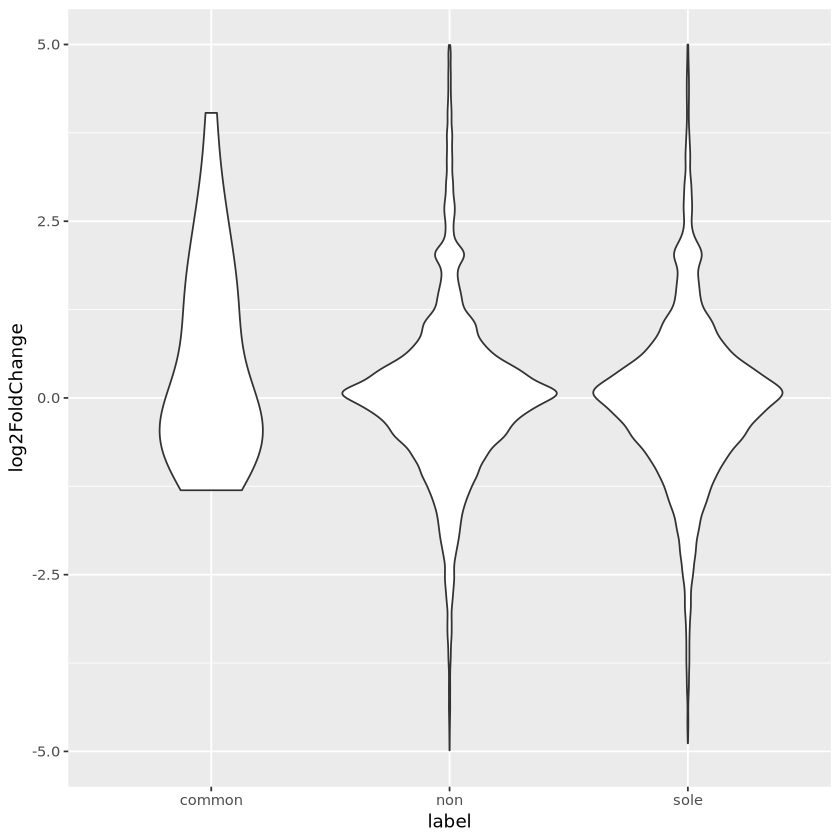

In [33]:
deseq2_df %>%
ggplot(aes(x=label,y=log2FoldChange))+
geom_violin()+
scale_y_continuous(limits = c(-5,5))